In [47]:
import numpy as np

import matplotlib.pyplot as plt

from gpflow.likelihoods import MultiClass, Gaussian
from gpflow.models.decoupled_svgp import DecoupledSVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from gpflow.kernels import RBF
from gpflow.models.svgp import SVGP



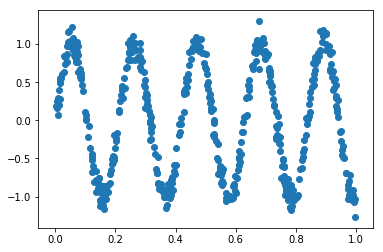

In [70]:
N = 500
Ns = 300
M_a = 10
M_b = 10
M = 10


Z_a = np.linspace(0, 1, M_a).reshape(-1, 1)
Z_B = np.linspace(0, 1, M_b).reshape(-1, 1)
Z = np.linspace(0, 1, M).reshape(-1, 1)

X = np.random.uniform(0, 1, N).reshape(-1, 1)
Xs = np.linspace(-0.5, 1.5, Ns).reshape(-1, 1)
Y = np.sin(30*X) + np.random.randn(*X.shape)*0.1

plt.scatter(X, Y)
plt.show()


In [71]:
model_decoupled = DecoupledSVGP(X, Y, RBF(1, lengthscales=0.1), Gaussian(), Z_a, Z_B)
model_svgp = SVGP(X, Y, RBF(1, lengthscales=0.1), Gaussian(), Z=Z)

model_decoupled.Z_a.set_trainable(False)
model_decoupled.Z_B.set_trainable(False)
model_svgp.feature.Z.set_trainable(False)

for model in model_decoupled, model_svgp:
    model.likelihood.variance = 0.1
    model.kern.set_trainable(False)
    model.likelihood.set_trainable(False)

In [72]:
for model in model_decoupled, model_svgp:
    ScipyOptimizer().minimize(model, maxiter=10000)
    

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 714.160630
  Number of iterations: 406
  Number of functions evaluations: 429
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 714.142507
  Number of iterations: 35
  Number of functions evaluations: 39


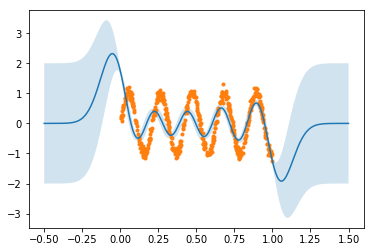

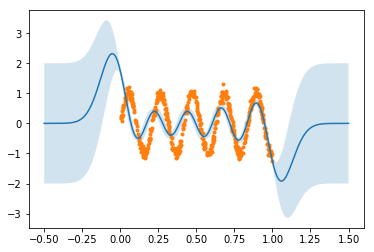

In [73]:
for model in model_decoupled, model_svgp:
    m, v = model.predict_f(Xs)
    plt.plot(Xs.flatten(), m)
    l, u = [m.flatten() + s * v.flatten()**0.5 for s in [-2., 2.]]
    plt.fill_between(Xs.flatten(), l, u, alpha=0.2)
    plt.scatter(X, Y, marker='.')
    plt.show()
    

In [74]:
model_decoupled.Z_a.set_trainable(True)
model_decoupled.Z_B.set_trainable(True)
model_svgp.feature.Z.set_trainable(True)

In [75]:
for model in model_decoupled, model_svgp:
    ScipyOptimizer().minimize(model, maxiter=10000)
    

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 87.604706
  Number of iterations: 10001
  Number of functions evaluations: 10593
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 135.856087
  Number of iterations: 2736
  Number of functions evaluations: 2924


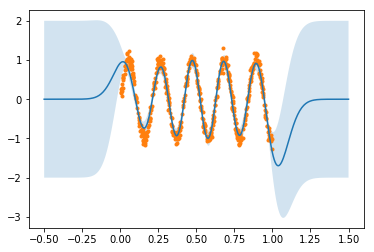

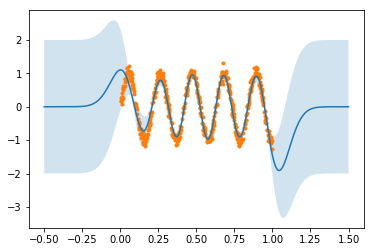

In [76]:
for model in model_decoupled, model_svgp:
    m, v = model.predict_f(Xs)
    plt.plot(Xs.flatten(), m)
    l, u = [m.flatten() + s * v.flatten()**0.5 for s in [-2., 2.]]
    plt.fill_between(Xs.flatten(), l, u, alpha=0.2)
    plt.scatter(X, Y, marker='.')
    plt.show()
    

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/', one_hot=False)


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [3]:
X, Y = mnist.train.next_batch(50000)
X_val, Y_val = mnist.validation.next_batch(5000)
Xs, Ys = mnist.test.next_batch(5000)

X = np.concatenate([X, X_val], 0)
Y = np.concatenate([Y, Y_val], 0)

X, Xs, Y, Ys = [x.astype(float) for x in [X, Xs, Y, Ys]]
Y, Ys = Y[:, None], Ys[:, None]

In [27]:
X, Xs, Y, Ys = [x[:200, :] for x in [X, Xs, Y, Ys]]
minibatch_size = None


In [28]:
print(X.shape)
print(Y.shape)
print(Xs.shape)
print(Ys.shape)

(100, 784)
(100, 1)
(100, 784)
(100, 1)


In [29]:
M_a = 200
M_b = 1

model_decoupled = DecoupledSVGP(X, Y, RBF(784, lengthscales=10.), MultiClass(10), 
                                X[:M_a, :].copy(), X[:M_b, :].copy(), 
                                num_latent=10, minibatch_size=minibatch_size)

model_svgp = SVGP(X, Y, RBF(784, lengthscales=10., variance=1.), MultiClass(10), 
                  Z=X[:M_b, :].copy(), 
                  num_latent=10, minibatch_size=minibatch_size)

for model in model_decoupled, model_svgp:
    model.kern.set_trainable(False)
    

In [30]:
for model in model_decoupled, model_svgp:
    print(model.compute_log_likelihood(initialize=True))
    print(model.compute_log_likelihood(initialize=True))

-820.479311927
-820.479311927
-819.513576025
-819.513576025


In [31]:
for model in model_decoupled, model_svgp:
    AdamOptimizer(0.01).minimize(model, maxiter=1000)

In [32]:
for model in model_decoupled, model_svgp:
    print(model.compute_log_likelihood(initialize=True))
    print(model.compute_log_likelihood(initialize=True))

-304.896935353
-304.896935353
-767.656336459
-767.656336459


In [33]:
def assess(model):
    pred_mean, pred_var = model.predict_y(Xs, initialize=True)
    pred = np.argmax(pred_mean, 1)
    acc = (pred.astype(int) == Ys.reshape(pred.shape).astype(int))
    acc = float(np.sum(acc))/float(len(Ys))*100.
    lik = np.average(model.predict_density(Xs, Ys))
    print('acc {:.4f} lik {:.4f}'.format(acc, lik))
    
    


In [34]:
for model in model_decoupled, model_svgp:
    assess(model)

acc 71.0000 lik -1.0540
acc 14.0000 lik -2.5662
